In [1]:
import cv2
import numpy as np
from skimage.morphology import disk, erosion
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
def read_every_nth_frame( video_capture, n):
	frame_count = 0
	frames = []
	while video_capture.isOpened():
		ret, frame = video_capture.read()

		if not ret:
			break

		if frame_count % n == 0:
			frames.append( cv2.cvtColor( frame, cv2.COLOR_BGR2RGB))

		frame_count += 1

	return np.array( frames)

In [ ]:
cap = cv2.VideoCapture( "image/MyRecord_20241116133821.mp4")

if cap.isOpened() == False:
	print( "Error Opening Video stream")

frames = read_every_nth_frame( cap, 1)

In [ ]:
frames.shape

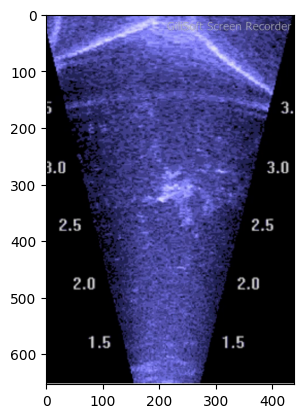

In [3]:
frame = cv2.imread( "sample.png")

frame = cv2.cvtColor( frame, cv2.COLOR_BGR2RGB)

plt.imshow( frame)

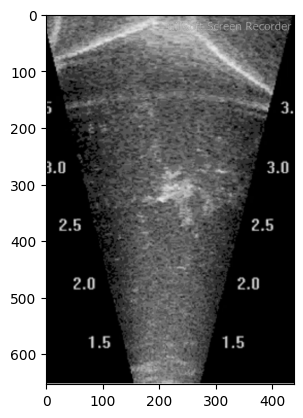

In [4]:
gray_frame = cv2.cvtColor( frame, cv2.COLOR_BGR2GRAY)

plt.imshow( gray_frame, cmap="gray")

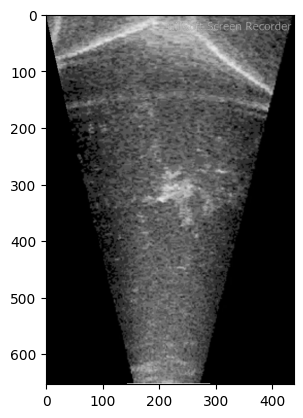

In [5]:
height, width = gray_frame.shape

mask = np.zeros_like( gray_frame)
# triangle = np.array( [ [ 0, height], [ width // 2, 0],  [ width, height]], np.int32)

polygon = np.array( [
	[ width * 0.33, height],	# Bottom-left
	[ width * 0.66, height],	# Botton-Right
	[ width, 0],				# Top-Right
	[ 0, 0],					# Top-Left
], np.int32)

mask = cv2.fillPoly( mask, [ polygon], 255)

masked_image = cv2.bitwise_and( gray_frame, mask)

plt.imshow( masked_image, cmap="gray")

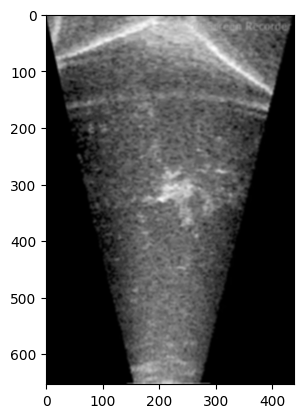

In [6]:
blurred_frame = cv2.GaussianBlur( masked_image, ( 5, 5), sigmaX=2, sigmaY=2)

plt.imshow( blurred_frame, cmap="gray")

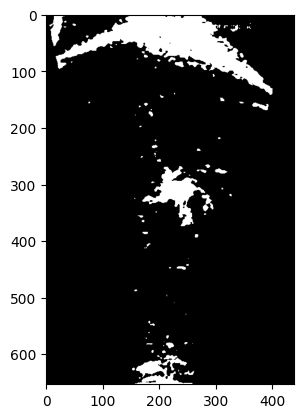

In [7]:
c = 0.5

_, binary_frame = cv2.threshold( blurred_frame, c * 255, 255, cv2.THRESH_BINARY)

plt.imshow( binary_frame, cmap="gray")

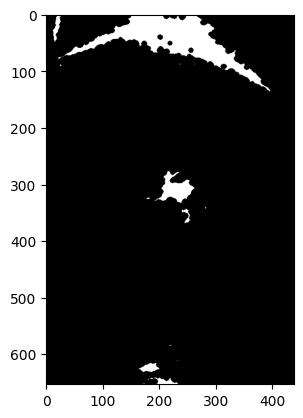

In [8]:
footprint = disk( 4)

eroded_frame = erosion( binary_frame, footprint)

plt.imshow( eroded_frame, cmap="gray")

In [9]:
bright_pixels = np.column_stack( np.where( eroded_frame > 0))

bright_pixels.shape

(15119, 2)

In [10]:
def Kmeans( X, k, lambda_, min_dist, tol=1e-4, max_iter=100, n_iter=10):
	
	# n: number of samples
	# f: number of features
	n, f = X.shape

	best_inertia = float( "inf")
	best_centeroids = None
	best_lables = None

	for _ in range( n_iter):
		
		np.random.seed()
		centeroids = X[ np.random.choice( n, k, replace=False)].astype( float)

		for _ in range( max_iter):
			new_centeroids = centeroids.copy()

			distances = np.linalg.norm( X[ :, np.newaxis] - centeroids, axis=2)
			
			labels = np.argmin( distances, axis=1)

			for i in range( k):
				co_dist = np.array( [ np.linalg.norm( centeroids[ i] - centeroids[ j]) for j in range( k)])

				if len( X[ labels == i]) > 0:
					gradient_1 = np.mean( X[ labels == i], axis=0) - centeroids[ i]
				else:
					gradient_1 = [ 0, 0]
					
				gradient_2 = lambda_ * ( ( centeroids[ i] - centeroids[ co_dist < min_dist]) * 0.5).sum( axis=0)
				
				new_centeroids[ i] += gradient_1 + gradient_2

			if np.linalg.norm( new_centeroids - centeroids) < tol:
				break

			centeroids = new_centeroids

		distances = np.linalg.norm( X[ :, np.newaxis] - centeroids, axis=2)
		inertia = np.sum( np.min( distances, axis=1) ** 2)

		if inertia < best_inertia:
			best_inertia = inertia
			best_centeroids = centeroids
			best_lables = labels

	return best_centeroids, best_lables


In [11]:
clusters, lables = Kmeans( X=bright_pixels,
						   lambda_=0.5,
						   k=7,
						   min_dist=30,
						   tol=1e-4,
						   max_iter=100,
						   n_iter=10)

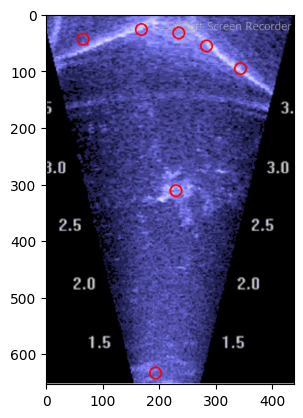

In [12]:
cluster_centers = clusters.astype( int)
output_image = frame.copy()

for c in cluster_centers:
	cv2.circle( output_image, ( c[ 1], c[ 0]), 10, ( 255, 0, 0), 2)

plt.imshow( output_image)

In [ ]:
def generate( frames):
	output = []

	for f in tqdm( frames):
		output_image = f.copy()

		gray_frame = cv2.cvtColor( f, cv2.COLOR_BGR2GRAY)

		height, width = gray_frame.shape

		mask = np.zeros_like( gray_frame)

		polygon = np.array( [
			[ width * 0.33, height],	# Bottom-left
			[ width * 0.66, height],	# Botton-Right
			[ width, 0],				# Top-Right
			[ 0, 0],					# Top-Left
		], np.int32)

		mask = cv2.fillPoly( mask, [ polygon], 255)

		masked_image = cv2.bitwise_and( gray_frame, mask)

		blurred_frame = cv2.GaussianBlur( masked_image, ( 5, 5), sigmaX=2, sigmaY=2)

		c = 0.5

		_, binary_frame = cv2.threshold( blurred_frame, c * 255, 255, cv2.THRESH_BINARY)

		footprint = disk( 4)

		eroded_frame = erosion( binary_frame, footprint)

		bright_pixels = np.column_stack( np.where( eroded_frame > 0))

		lambda_ = 0.5
		k = 7
		min_dist = 30
		tol = 1e-4
		max_iter = 50
		n_iter = 5
		
		if len( bright_pixels) < 1:
			output.append( output_image)
			continue

		clusters, lables = Kmeans( X=bright_pixels,
								   lambda_=lambda_,
								   k=k,
								   min_dist=min_dist,
								   tol=tol,
								   max_iter=max_iter,
								   n_iter=n_iter)

		cluster_centers = clusters.astype( int)

		for c in cluster_centers:
			cv2.circle( output_image, ( c[ 1], c[ 0]), 10, ( 255, 0, 0), 2)

		output.append( output_image)

	return output

In [ ]:
o = generate( frames)

In [ ]:
height, width, _ = o[ 0].shape

fourcc = cv2.VideoWriter_fourcc( *"MP4V")
video = cv2.VideoWriter( "video.mp4", fourcc, 24, ( width, height))

for f in o:
	video.write( cv2.cvtColor( f, cv2.COLOR_RGB2BGR))

video.release()